In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from models import Model
from dataset import H5Dataset

In [2]:
data = H5Dataset("data/tetrominoes.h5")
train_loader = DataLoader(data, batch_size=32, shuffle=True)

resolution = (35, 35)
num_slots, num_iterations, hidden_dim = 4, 4, 32
model = Model(resolution, num_slots, num_iterations, hidden_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [3]:
def test(model, train_loader):
    model.eval()
    renormalize = lambda x: (x + 1) / 2
    with torch.no_grad():
        image = next(iter(train_loader))["image"][0]
        image = image.unsqueeze(0)
        recon_combined, recons, masks, slots = model(image)

        fig, ax = plt.subplots(1, num_slots + 2, figsize=(10, 2))
        image = image.squeeze(0)
        recon_combined = recon_combined.squeeze(0)
        recons = recons.squeeze(0)
        masks = masks.squeeze(0)
        image = image.permute(1, 2, 0).numpy()

        recon_combined = recon_combined.permute(1, 2, 0)
        recon_combined = recon_combined.detach().numpy()

        image = renormalize(image)
        recon_combined = renormalize(recon_combined)
        ax[0].imshow(image)
        ax[1].imshow(recon_combined)
        for i in range(num_slots):
            picture = recons[i] * masks[i] + (1 - masks[i])
            picture = picture.permute(1, 2, 0).detach().numpy()
            picture = renormalize(picture)
            ax[i + 2].imshow(picture)
        for i in range(len(ax)):
            ax[i].grid(False)
            ax[i].axis("off")

        plt.show()

/Users/home/miniconda3/envs/svae/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


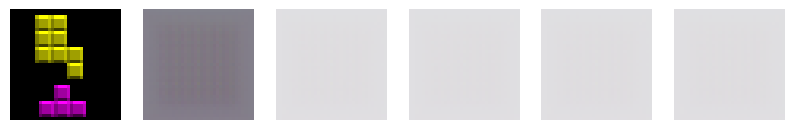

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054303825..0.50051415].


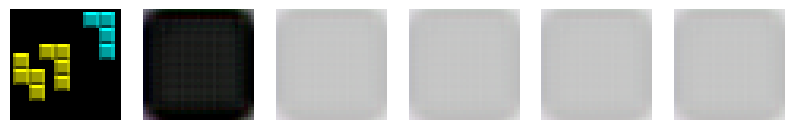

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.074990034..0.4649231].


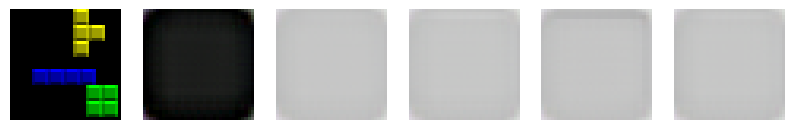

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.102927685..0.41462448].


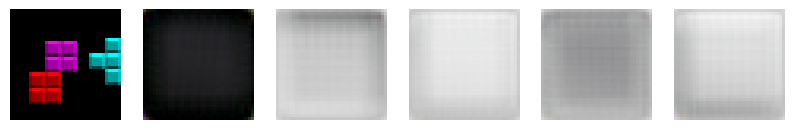

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1286084..0.3335049].


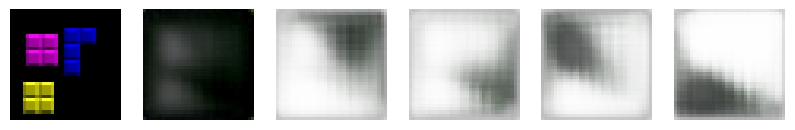

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0815652..0.43707332].


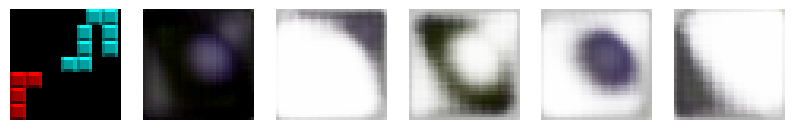

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10710037..0.5984546].


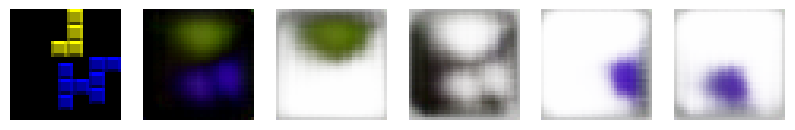

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09450668..0.35081747].


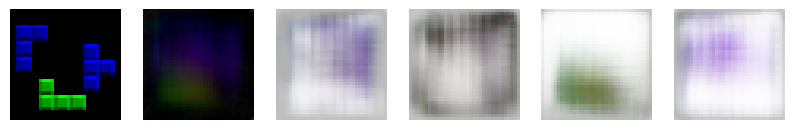

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12017071..0.5317556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040056527..0.978499].


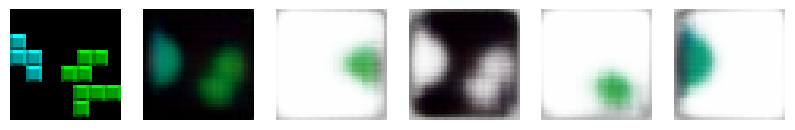

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.084572434..0.6581342].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03584826..0.9834417].


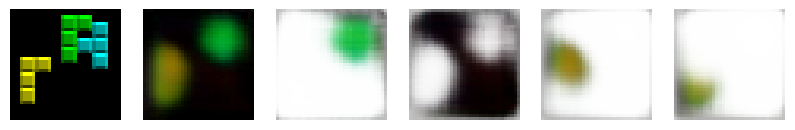

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.052940965..0.57793623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030142784..0.9408686].


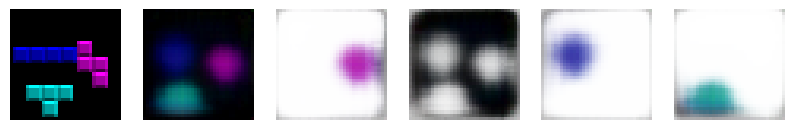

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04888904..0.5792975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030793905..0.9504618].


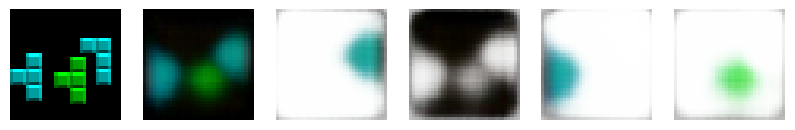

In [4]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    for idx, sample in enumerate(train_loader):        
        image = sample['image']
        recon_combined, recons, masks, slots = model(image)
        loss = criterion(recon_combined, image)
        total_loss = total_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            test(model, train_loader)

    total_loss /= len(train_loader)
    print (f"epoch {epoch}: {total_loss:.3f}")